### PLOTS

### Task 1.1

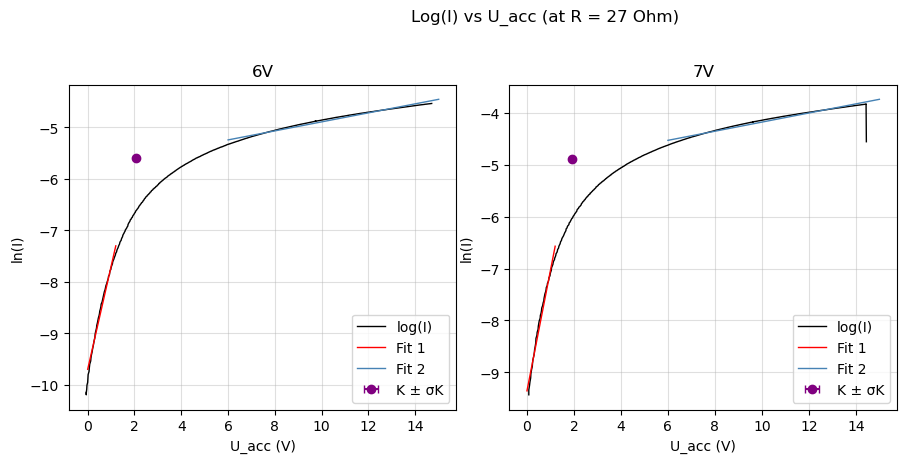

K_6V = 2.057 ± 0.036 V
K_7V = 1.924 ± 0.041 V
Weighted average K = 2.000 ± 0.027 V


In [2]:
"""
Frank–Hertz tube: ln(I) vs U_acc at two heater voltages
======================================================
This script
-----------
* downloads the 6 V and 7 V data files directly from GitHub,
* converts to accelerating voltage U_acc = V_supply – I·R (R = 27 Ω),
* draws ln(I) vs U_acc in two panels with two linear‐fit segments each,
* finds the intersection of the two fits → contact potential K,
* **propagates statistical uncertainties** from the linear regressions to K
  and prints the result with error bars.

Requires: numpy, pandas, matplotlib, scipy (for curve_fit).
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import sqrt

# -----------------------------------------------------------
# 1. download raw data
# -----------------------------------------------------------
URL_6V = (
    "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/"
    "Frank%20Hertz%20Data/Task%201.1%206V.txt"
)
URL_7V = (
    "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/refs/heads/main/"
    "Frank%20Hertz%20Data/Task%201.1%207V.txt"
)

df6 = pd.read_csv(URL_6V, delim_whitespace=True, names=["V_supply", "I"])
df7 = pd.read_csv(URL_7V, delim_whitespace=True, names=["V_supply", "I"])

# -----------------------------------------------------------
# 2. preprocess: keep positive currents, compute U_acc & lnI
# -----------------------------------------------------------
R = 27.0  # Ω

def prep(df):
    df = df[df["I"] > 0].copy()
    df["U_acc"] = df["V_supply"] - R * df["I"]
    df["lnI"] = np.log(df["I"])
    return df

df6, df7 = map(prep, (df6, df7))

# -----------------------------------------------------------
# 3. helper: straight line + wrapper to fit with covariance
# -----------------------------------------------------------

def line(x, m, b):
    return m * x + b


def fit_line(x, y, x_min, x_max):
    mask = (x >= x_min) & (x <= x_max)
    popt, pcov = curve_fit(line, x[mask], y[mask])  # popt = [m, b]
    m, b = popt
    dm, db = np.sqrt(np.diag(pcov))
    return m, b, dm, db

# fit windows
FIT_LOW = (0.0, 1.2)
FIT_MID = (6.0, 15.0)

# -----------------------------------------------------------
# 4. perform fits and error propagation for each heater voltage
# -----------------------------------------------------------
results = {}
for label, df in (("6V", df6), ("7V", df7)):
    m1, b1, dm1, db1 = fit_line(df["U_acc"], df["lnI"], *FIT_LOW)
    m2, b2, dm2, db2 = fit_line(df["U_acc"], df["lnI"], *FIT_MID)

    # intersection: U_int = (b2 - b1)/(m1 - m2)
    U_int = (b2 - b1) / (m1 - m2)

    # propagate error: dU_int from partial derivatives
    dU = sqrt(
        (db1 / (m1 - m2)) ** 2
        + (db2 / (m1 - m2)) ** 2
        + ((b2 - b1) * dm1 / (m1 - m2) ** 2) ** 2
        + ((b2 - b1) * dm2 / (m1 - m2) ** 2) ** 2
    )

    results[label] = {
        "m1": m1,
        "b1": b1,
        "dm1": dm1,
        "db1": db1,
        "m2": m2,
        "b2": b2,
        "dm2": dm2,
        "db2": db2,
        "K": U_int,
        "dK": dU,
    }

# -----------------------------------------------------------
# 5. plot
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
for ax, (label, df) in zip(axes, (("6V", df6), ("7V", df7))):
    res = results[label]

    # raw data
    ax.plot(df["U_acc"], df["lnI"], color="black", lw=1, label="log(I)")

    # fits
    for (m, b, rng, color, tag) in [
        (res["m1"], res["b1"], FIT_LOW, "red", "Fit 1"),
        (res["m2"], res["b2"], FIT_MID, "steelblue", "Fit 2"),
    ]:
        x = np.linspace(*rng, 100)
        ax.plot(x, line(x, m, b), color=color, lw=1, label=tag)

    # intersection marker with error bar
    ax.errorbar(
        res["K"],
        line(res["K"], res["m1"], res["b1"]),
        xerr=res["dK"],
        fmt="o",
        color="purple",
        capsize=3,
        label="K ± σK",
    )

    ax.set_xlabel("U_acc (V)")
    ax.set_ylabel("ln(I)")
    ax.set_title(f"{label}")
    ax.grid(alpha=0.4)
    ax.legend()

fig.suptitle("Log(I) vs U_acc (at R = 27 Ohm)", y=1.02)
plt.tight_layout()
# after all your ax / fig setup but before plt.show()
fig.subplots_adjust(right=0.82, hspace=0.35)   # keep layout tweak

# HIGH‑RES saves
fig.savefig("1.png", dpi=300, bbox_inches="tight")
fig.savefig("Hg_ionisation.svg", bbox_inches="tight")  # vector version

plt.show()

# -----------------------------------------------------------
# 6. print numerical results
# -----------------------------------------------------------
for lbl in ("6V", "7V"):
    print(
        f"K_{lbl} = {results[lbl]['K']:.3f} ± {results[lbl]['dK']:.3f} V"
    )

K_avg = np.average([results[l]['K'] for l in ("6V", "7V")],
                   weights=[1/results[l]['dK']**2 for l in ("6V", "7V")])

sigma_avg = sqrt(1 / sum(1 / results[l]['dK']**2 for l in ("6V", "7V")))
print(f"Weighted average K = {K_avg:.3f} ± {sigma_avg:.3f} V")


### Task 1.2

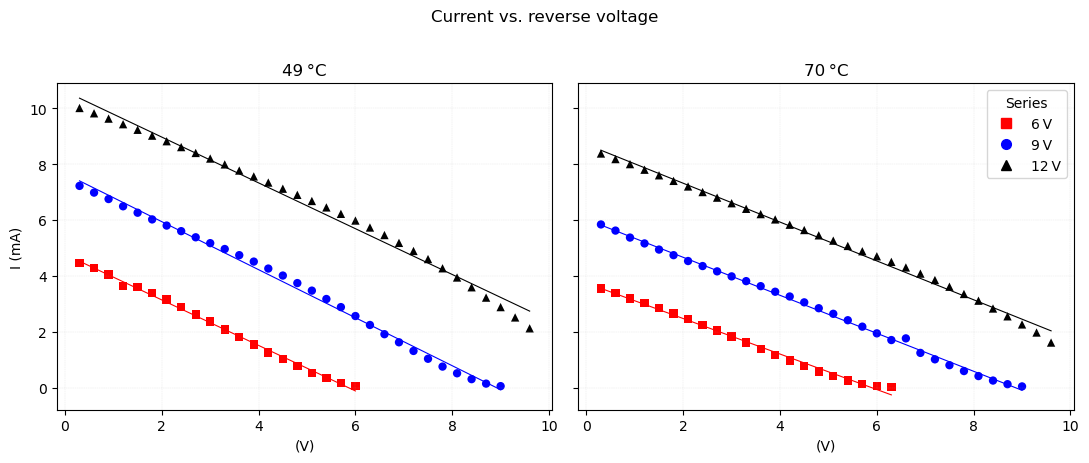

In [3]:
"""
Frank–Hertz Task 2.2 – velocity / energy distribution
=====================================================
Plots the electron current *I* versus reverse voltage *V* at two oven
temperatures (49 °C and 70 °C) for three heater settings (6 V, 9 V, 12 V).

* red  ■  = y₆  (6 V heater)
* blue ●  = y₉  (9 V heater)
* black ▲ = y₁₂ (12 V heater)
"""
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# ────────────────────────────
# 1. raw data pasted as strings
# ────────────────────────────
RAW_49 = """
x y_6 y_9 y_12
0.3 4.47 7.22 10.01
0.6 4.28 6.98 9.82
0.9 4.05 6.75 9.63
1.2 3.63 6.49 9.43
1.5 3.61 6.26 9.23
1.8 3.38 6.02 9.02
2.1 3.15 5.8 8.82
2.4 2.89 5.6 8.61
2.7 2.62 5.38 8.4
3   2.37 5.17 8.2
3.3 2.08 4.96 7.99
3.6 1.8  4.74 7.77
3.9 1.54 4.51 7.56
4.2 1.26 4.26 7.34
4.5 1.01 4.01 7.12
4.8 0.78 3.74 6.9
5.1 0.53 3.47 6.68
5.4 0.33 3.17 6.45
5.7 0.16 2.88 6.22
6   0.06 2.56 5.98
6.3 NaN  2.24 5.73
6.6 NaN  1.91 5.46
6.9 NaN  1.62 5.18
7.2 NaN  1.31 4.89
7.5 NaN  1.03 4.6
7.8 NaN  0.75 4.27
8.1 NaN  0.51 3.94
8.4 NaN  0.3  3.59
8.7 NaN  0.14 3.22
9   NaN  0.05 2.88
9.3 NaN  NaN  2.51
9.6 NaN  NaN  2.12
"""

RAW_70 = """
x y_6 y_9 y_12
0.3 3.546 5.84 8.38
0.6 3.374 5.62 8.18
0.9 3.19  5.37 8
1.2 3.02  5.16 7.8
1.5 2.84  4.94 7.6
1.8 2.65  4.74 7.4
2.1 2.45  4.53 7.2
2.4 2.25  4.35 7
2.7 2.04  4.16 6.8
3   1.83  3.98 6.6
3.3 1.61  3.81 6.4
3.6 1.39  3.63 6.21
3.9 1.17  3.43 6.02
4.2 0.97  3.26 5.83
4.5 0.76  3.05 5.64
4.8 0.58  2.84 5.45
5.1 0.41  2.64 5.26
5.4 0.25  2.41 5.07
5.7 0.13  2.18 4.88
6   0.05  1.94 4.7
6.3 0.01  1.7  4.5
6.6 NaN   1.76 4.3
6.9 NaN   1.24 4.08
7.2 NaN   1.01 3.85
7.5 NaN   0.8  3.61
7.8 NaN   0.59 3.35
8.1 NaN   0.41 3.11
8.4 NaN   0.25 2.83
8.7 NaN   0.12 2.55
9   NaN   0.04 2.26
9.3 NaN   NaN  1.97
9.6 NaN   NaN  1.61
9.7 NaN   NaN  NaN
"""

def to_df(raw: str) -> pd.DataFrame:
    """Convert raw multiline string to DataFrame; numeric columns only."""
    return pd.read_csv(io.StringIO(raw), delim_whitespace=True)

df49, df70 = map(to_df, (RAW_49, RAW_70))

# ────────────────────────────
# 2. plotting parameters
# ────────────────────────────
STYLE = {
    "y_6":  {"color": "red",   "marker": "s", "label": "6 V"},
    "y_9":  {"color": "blue",  "marker": "o", "label": "9 V"},
    "y_12": {"color": "black", "marker": "^", "label": "12 V"},
}

# ────────────────────────────
# 3. build the figure
# ────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True)

for ax, df, title in zip(axes, (df49, df70), ("49 °C", "70 °C")):
    for col, st in STYLE.items():
        data = df[["x", col]].dropna()
        if data.empty:
            continue

        # scatter points
        ax.scatter(data["x"], data[col],
                   color=st["color"], marker=st["marker"], edgecolor="none")

        # optional linear guide
        if len(data) > 1:
            m, b = np.polyfit(data["x"], data[col], 1)
            xfit = np.linspace(data["x"].min(), data["x"].max(), 200)
            ax.plot(xfit, m * xfit + b, color=st["color"], lw=0.8)

    ax.set_title(title)
    ax.set_xlabel("(V)")
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.grid(True, ls="--", lw=0.3, alpha=0.35)

axes[0].set_ylabel("I (mA)")

# clean legend using custom handles
handles = [
    Line2D([], [], marker=STYLE[c]["marker"], color=STYLE[c]["color"],
           ls="none", markersize=7, label=STYLE[c]["label"])
    for c in ("y_6", "y_9", "y_12")
]
axes[1].legend(handles=handles, title="Series", loc="upper right")

fig.suptitle("Current vs. reverse voltage", y=1.02)
fig.tight_layout()
# ... your plotting code ...

# save a 300‑dpi PNG (≈ print quality 8×7 inch figure)
plt.savefig("2.png", dpi=300, bbox_inches="tight")

# optional: also save as vector PDF or SVG (infinite resolution)
plt.savefig("ionisation_curves.pdf", bbox_inches="tight")
# plt.savefig("ionisation_curves.svg", bbox_inches="tight")

plt.show()          # keep if you still want the interactive window



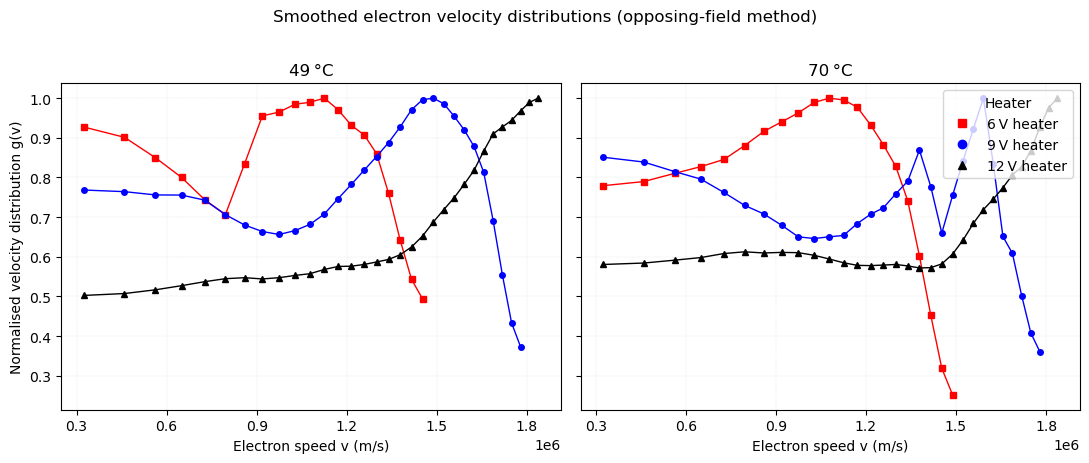

In [4]:
"""
Frank–Hertz experiment – Task 2.3
=================================
Velocity‑distribution curves g(v) obtained from the opposing‑field (retarding)
method.  Uses your tabulated I‑vs‑U data at 49 °C and 70 °C, three heater
currents (6 V, 9 V, 12 V).

Procedure
---------
1.  Smooth each I(U) trace with a Savitzky–Golay filter.
2.  Differentiate: g(U) ∝ –dI/dU.
3.  Convert retarding voltage  U  →  electron speed
       v = √(2 e U / mₑ).
4.  Normalise g(v) for each series and plot the six curves.

Colour / marker map
-------------------
* **y₆**  →  red   ■  squares   (6 V heater)
* **y₉**  →  blue  ●  circles   (9 V heater)
* **y₁₂** →  black ▲  triangles (12 V heater)
"""
# -----------------------------------------------------------------------------#
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter

# Physical constants
e_charge = 1.602176634e-19   # C
m_e      = 9.1093837015e-31  # kg

# ── raw tables pasted from your message ───────────────────────────────────────
RAW_49 = """\
x y_6 y_9 y_12
0.3 4.47 7.22 10.01
0.6 4.28 6.98 9.82
0.9 4.05 6.75 9.63
1.2 3.63 6.49 9.43
1.5 3.61 6.26 9.23
1.8 3.38 6.02 9.02
2.1 3.15 5.8 8.82
2.4 2.89 5.6 8.61
2.7 2.62 5.38 8.4
3   2.37 5.17 8.2
3.3 2.08 4.96 7.99
3.6 1.8  4.74 7.77
3.9 1.54 4.51 7.56
4.2 1.26 4.26 7.34
4.5 1.01 4.01 7.12
4.8 0.78 3.74 6.9
5.1 0.53 3.47 6.68
5.4 0.33 3.17 6.45
5.7 0.16 2.88 6.22
6   0.06 2.56 5.98
6.3 NaN  2.24 5.73
6.6 NaN  1.91 5.46
6.9 NaN  1.62 5.18
7.2 NaN  1.31 4.89
7.5 NaN  1.03 4.6
7.8 NaN  0.75 4.27
8.1 NaN  0.51 3.94
8.4 NaN  0.3  3.59
8.7 NaN  0.14 3.22
9   NaN  0.05 2.88
9.3 NaN  NaN  2.51
9.6 NaN  NaN  2.12
"""

RAW_70 = """\
x y_6 y_9 y_12
0.3 3.546 5.84 8.38
0.6 3.374 5.62 8.18
0.9 3.19  5.37 8
1.2 3.02  5.16 7.8
1.5 2.84  4.94 7.6
1.8 2.65  4.74 7.4
2.1 2.45  4.53 7.2
2.4 2.25  4.35 7
2.7 2.04  4.16 6.8
3   1.83  3.98 6.6
3.3 1.61  3.81 6.4
3.6 1.39  3.63 6.21
3.9 1.17  3.43 6.02
4.2 0.97  3.26 5.83
4.5 0.76  3.05 5.64
4.8 0.58  2.84 5.45
5.1 0.41  2.64 5.26
5.4 0.25  2.41 5.07
5.7 0.13  2.18 4.88
6   0.05  1.94 4.7
6.3 0.01  1.7  4.5
6.6 NaN   1.76 4.3
6.9 NaN   1.24 4.08
7.2 NaN   1.01 3.85
7.5 NaN   0.8  3.61
7.8 NaN   0.59 3.35
8.1 NaN   0.41 3.11
8.4 NaN   0.25 2.83
8.7 NaN   0.12 2.55
9   NaN   0.04 2.26
9.3 NaN   NaN  1.97
9.6 NaN   NaN  1.61
9.7 NaN   NaN  NaN
"""

# utility to convert the raw string to DataFrame
to_df = lambda raw: pd.read_csv(io.StringIO(raw), delim_whitespace=True)
df49, df70 = map(to_df, (RAW_49, RAW_70))

# plotting style map
STYLE = {
    "y_6":  {"color": "red",   "marker": "s", "label": "6 V heater"},
    "y_9":  {"color": "blue",  "marker": "o", "label": "9 V heater"},
    "y_12": {"color": "black", "marker": "^", "label": "12 V heater"},
}

# helper functions
voltage_to_speed = lambda U: np.sqrt(2 * e_charge * U / m_e)
derivative       = lambda x, y: np.gradient(y, x)

def smooth(y, window=7, poly=2):
    """Savitzky–Golay smoothing (odd window length)."""
    if len(y) < window:
        return y
    if window % 2 == 0:
        window += 1
    return savgol_filter(y, window_length=window, polyorder=poly)

# ── build the figure ──────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True)

for ax, df, title in zip(axes, (df49, df70), ("49 °C", "70 °C")):
    for col, st in STYLE.items():
        sub = df[["x", col]].dropna()
        if sub.empty:
            continue
        U = sub["x"].values                 # V
        I = sub[col].values * 1e-3          # mA → A
        I_s = smooth(I)                     # smoothed current
        gU  = -derivative(U, I_s)           # -dI/dU
        v   = voltage_to_speed(U)           # m/s
        g_norm = gU / gU.max()              # normalise
        ax.plot(v, g_norm, color=st["color"],
                marker=st["marker"], ms=4, lw=1,
                label=st["label"])

    ax.set_title(title)
    ax.set_xlabel("Electron speed v (m/s)")
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.grid(True, ls="--", lw=0.3, alpha=0.35)

axes[0].set_ylabel("Normalised velocity distribution g(v)")

# legend
handles = [Line2D([], [], marker=STYLE[k]["marker"], color=STYLE[k]["color"],
                  ls="none", markersize=6, label=STYLE[k]["label"])
           for k in STYLE]
axes[1].legend(handles=handles, title="Heater", loc="upper right")

fig.suptitle("Smoothed electron velocity distributions (opposing‑field method)",
             y=1.02)
fig.tight_layout()
# ... your plotting code ...

# save a 300‑dpi PNG (≈ print quality 8×7 inch figure)
plt.savefig("3.png", dpi=300, bbox_inches="tight")

# optional: also save as vector PDF or SVG (infinite resolution)
plt.savefig("ionisation_curves.pdf", bbox_inches="tight")
# plt.savefig("ionisation_curves.svg", bbox_inches="tight")

plt.show()          # keep if you still want the interactive window


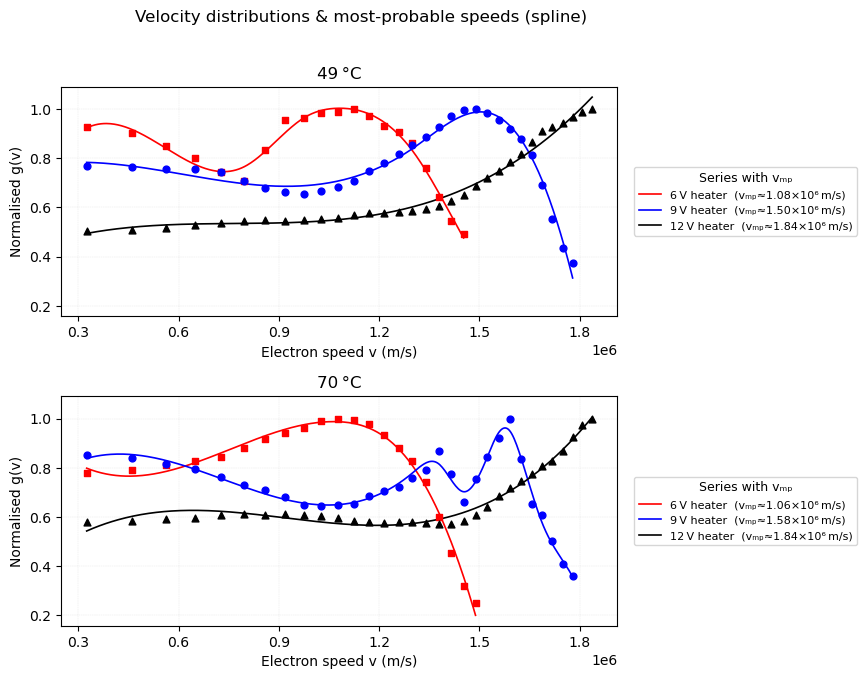


Most‑probable electron speeds (m/s)
Temperature      6 V heater      9 V heater      12 V heater
      49 °C     1.08e+06     1.50e+06     1.84e+06
      70 °C     1.06e+06     1.58e+06     1.84e+06


In [5]:
"""
Frank–Hertz – velocity distributions & most‑probable speeds
===========================================================
Smoothed I(U) → g(U) → g(v), cubic‑spline fit, most‑probable velocity.

Layout
------
* Two stacked panels: 49 °C (top), 70 °C (bottom)
* Each panel has its own legend just to the right.
* Marker / colour map:
    • 6 V heater  – red   ■
    • 9 V heater  – blue  ●
    • 12 V heater – black ▲
"""
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline

# ─── physical constants ──────────────────────────────────────────────
_e = 1.602_176_634e-19       # C
_m = 9.109_383_7015e-31      # kg
_to_v = lambda U: np.sqrt(2 * _e * U / _m)   # voltage → speed (m s⁻¹)

# ─── helpers ─────────────────────────────────────────────────────────
def _smooth(y, win=7, poly=2):
    if len(y) < win:
        return y
    win += (win % 2 == 0)    # ensure odd
    return savgol_filter(y, win, poly)

def _spline(x, y, frac=5e-4):
    """Cubic smoothing spline."""
    s = frac * len(x) * y.max()
    return UnivariateSpline(x, y, s=s)

# ─── raw I‑U tables ─────────────────────────────────────────────────
RAW_49 = """x y_6 y_9 y_12
0.3 4.47 7.22 10.01
0.6 4.28 6.98 9.82
0.9 4.05 6.75 9.63
1.2 3.63 6.49 9.43
1.5 3.61 6.26 9.23
1.8 3.38 6.02 9.02
2.1 3.15 5.8 8.82
2.4 2.89 5.6 8.61
2.7 2.62 5.38 8.4
3   2.37 5.17 8.2
3.3 2.08 4.96 7.99
3.6 1.8  4.74 7.77
3.9 1.54 4.51 7.56
4.2 1.26 4.26 7.34
4.5 1.01 4.01 7.12
4.8 0.78 3.74 6.9
5.1 0.53 3.47 6.68
5.4 0.33 3.17 6.45
5.7 0.16 2.88 6.22
6   0.06 2.56 5.98
6.3 NaN  2.24 5.73
6.6 NaN  1.91 5.46
6.9 NaN  1.62 5.18
7.2 NaN  1.31 4.89
7.5 NaN  1.03 4.6
7.8 NaN  0.75 4.27
8.1 NaN  0.51 3.94
8.4 NaN  0.3  3.59
8.7 NaN  0.14 3.22
9   NaN  0.05 2.88
9.3 NaN  NaN  2.51
9.6 NaN  NaN  2.12
"""

RAW_70 = """x y_6 y_9 y_12
0.3 3.546 5.84 8.38
0.6 3.374 5.62 8.18
0.9 3.19  5.37 8
1.2 3.02  5.16 7.8
1.5 2.84  4.94 7.6
1.8 2.65  4.74 7.4
2.1 2.45  4.53 7.2
2.4 2.25  4.35 7
2.7 2.04  4.16 6.8
3   1.83  3.98 6.6
3.3 1.61  3.81 6.4
3.6 1.39  3.63 6.21
3.9 1.17  3.43 6.02
4.2 0.97  3.26 5.83
4.5 0.76  3.05 5.64
4.8 0.58  2.84 5.45
5.1 0.41  2.64 5.26
5.4 0.25  2.41 5.07
5.7 0.13  2.18 4.88
6   0.05  1.94 4.7
6.3 0.01  1.7  4.5
6.6 NaN   1.76 4.3
6.9 NaN   1.24 4.08
7.2 NaN   1.01 3.85
7.5 NaN   0.8  3.61
7.8 NaN   0.59 3.35
8.1 NaN   0.41 3.11
8.4 NaN   0.25 2.83
8.7 NaN   0.12 2.55
9   NaN   0.04 2.26
9.3 NaN   NaN  1.97
9.6 NaN   NaN  1.61
9.7 NaN   NaN  NaN
"""

def _read(raw: str) -> pd.DataFrame:
    """Parse raw string to DataFrame with columns x, y_6, y_9, y_12."""
    return pd.read_csv(io.StringIO(raw), delim_whitespace=True,
                       skiprows=1, names=["x", "y_6", "y_9", "y_12"])

df49, df70 = map(_read, (RAW_49, RAW_70))

# ─── style map ────────────────────────────────────────────────────────
STYLE = {
    "y_6":  {"c": "red",   "m": "s", "lab": "6 V heater"},
    "y_9":  {"c": "blue",  "m": "o", "lab": "9 V heater"},
    "y_12": {"c": "black", "m": "^", "lab": "12 V heater"},
}

# ─── main routine ────────────────────────────────────────────────────
def velocity_distribution_plot():
    """Plot g(v) curves and print most‑probable speeds."""
    v_peak = {"49 °C": {}, "70 °C": {}}

    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharey=True)

    for ax, df, Tlab in zip(axes, (df49, df70), ("49 °C", "70 °C")):
        for col, st in STYLE.items():
            sub = df[["x", col]].dropna()
            if sub.empty:
                continue
            U = sub["x"].to_numpy()
            I = sub[col].to_numpy() * 1e-3               # mA → A
            gU = -np.gradient(_smooth(I), U)             # -dI/dU
            v  = _to_v(U)
            g  = gU / gU.max()

            spl  = _spline(v, g)
            v_f  = np.linspace(v.min(), v.max(), 400)
            g_f  = spl(v_f)
            v_mp = v_f[g_f.argmax()]
            v_peak[Tlab][col] = v_mp

            ax.scatter(v, g, color=st["c"], marker=st["m"], s=24, zorder=3)
            ax.plot(v_f, g_f, color=st["c"], lw=1.2,
                    label=f"{st['lab']}  (vₘₚ≈{v_mp/1e6:.2f}×10⁶ m/s)")

        # cosmetics and per‑panel legend
        ax.set_title(Tlab)
        ax.set_xlabel("Electron speed v (m/s)")
        ax.xaxis.set_major_locator(MaxNLocator(6))
        ax.grid(True, ls="--", lw=0.3, alpha=0.35)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=8, title="Series with vₘₚ",
                  title_fontsize=9,
                  loc="center left", bbox_to_anchor=(1.02, 0.5))

    axes[0].set_ylabel("Normalised g(v)")
    axes[1].set_ylabel("Normalised g(v)")

    fig.subplots_adjust(right=0.82, hspace=0.35)
    fig.suptitle("Velocity distributions & most‑probable speeds (spline)", y=0.99)
    # ... your plotting code ...

    # save a 300‑dpi PNG (≈ print quality 8×7 inch figure)
    plt.savefig("task.png", dpi=300, bbox_inches="tight")

    # optional: also save as vector PDF or SVG (infinite resolution)
    plt.savefig("ionisation_curves.pdf", bbox_inches="tight")
    # plt.savefig("ionisation_curves.svg", bbox_inches="tight")

        # ... your plotting code ...

    # save a 300‑dpi PNG (≈ print quality 8×7 inch figure)
    plt.savefig("3.png", dpi=300, bbox_inches="tight")

    # optional: also save as vector PDF or SVG (infinite resolution)
    plt.savefig("ionisation_curves.pdf", bbox_inches="tight")
    # plt.savefig("ionisation_curves.svg", bbox_inches="tight")

    plt.show()          # keep if you still want the interactive window
              # keep if you still want the interactive window


    # numeric table
    print("\nMost‑probable electron speeds (m/s)")
    print("Temperature      6 V heater      9 V heater      12 V heater")
    for T in ("49 °C", "70 °C"):
        r = v_peak[T]
        print(f"{T:>11}   "
              f"{r.get('y_6', np.nan):10.2e}   "
              f"{r.get('y_9', np.nan):10.2e}   "
              f"{r.get('y_12', np.nan):10.2e}")

# ---------------------------------------------------------------------------------
# Run the routine when executed as a script
# ---------------------------------------------------------------------------------
if __name__ == "__main__":
    velocity_distribution_plot()


### task 1.3

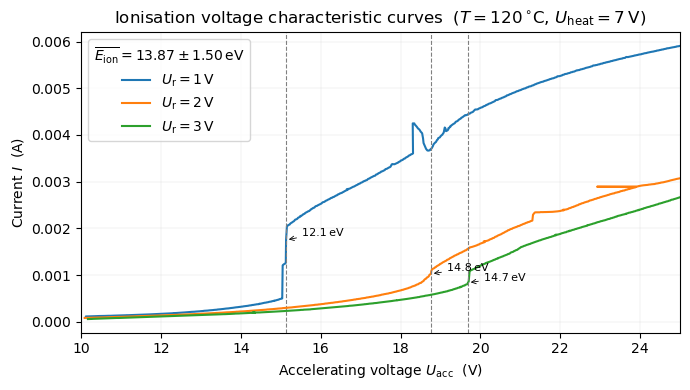

Contact potential K = 1.990 V

Reverse V   U_knee (V)   E_ion (eV)
        1        15.13        12.14
        2        18.76        14.77
        3        19.69        14.70

Average E_ion = 13.87 ± 1.50 eV  (1σ, n=3)
Standard error of mean  = ±0.86 eV


In [3]:
# Frank–Hertz – Task 3 (final tweak)
# Ionisation voltage from knee in I‑U curves (1 V, 2 V, 3 V reverse)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# fixed parameters
R_series = 27.0
K_contact = 1.9905
PLOT_MIN, PLOT_MAX = 10, 25
SG_WIN, SG_POLY = 7, 2

root = ("https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/"
        "refs/heads/main/Frank%20Hertz%20Data/")
urls = {1: root+"task%201.3%201V.txt",
        2: root+"task%201.3%202V.txt",
        3: root+"task%201.3%203V.txt"}

#   U_ret : (win_min , win_max)
search_win = {1: (13, 17),
              2: (17, 22),
              3: (17, 22)}

fig, ax = plt.subplots(figsize=(7, 4))
results = []

for U_ret, url in urls.items():
    df = pd.read_csv(url, delim_whitespace=True, names=["V_s", "I"])
    df["U_acc"] = df["V_s"] - R_series * df["I"]

    # plot window
    df_plot = df[(df["U_acc"] >= PLOT_MIN) & (df["U_acc"] <= PLOT_MAX)]
    ax.plot(df_plot["U_acc"], df_plot["I"],
        label=f"$U_{{\\mathrm{{r}}}}={U_ret}\\,\\mathrm{{V}}$")

    # knee search in series‑specific window
    w_min, w_max = search_win[U_ret]
    df_win = df[(df["U_acc"] >= w_min) & (df["U_acc"] <= w_max)].reset_index(drop=True)
    I_sm = savgol_filter(df_win["I"], SG_WIN, SG_POLY)
    dIdU = np.gradient(I_sm, df_win["U_acc"])
    idx = np.argmax(dIdU)
    U_knee, I_knee = df_win.at[idx, "U_acc"], df_win.at[idx, "I"]

    E_ion = U_knee - U_ret - K_contact
    results.append((U_ret, U_knee, E_ion))

    # annotate knee
    ax.axvline(U_knee, ls="--", color="gray", lw=0.8)
    ax.annotate(f"{E_ion:.1f} eV",
                xy=(U_knee, I_knee),
                xytext=(U_knee + 0.4, I_knee * 1.05),
                arrowprops=dict(arrowstyle="->", lw=0.6),
                fontsize=8)

# ----- analysis & output -------------------------------------------------
# convert to array for stats
E_vals = np.array([E for _, _, E in results])
mean_E = E_vals.mean()
std_E = E_vals.std(ddof=1)           # sample standard deviation
sem_E = std_E / np.sqrt(len(E_vals)) # standard error of the mean

# figure cosmetics
ax.set_xlim(PLOT_MIN, PLOT_MAX)
ax.set_xlabel("Accelerating voltage $U_{\\text{acc}}$  (V)")
ax.set_ylabel("Current $I$  (A)")
ax.set_title("Ionisation voltage characteristic curves  "
             "($T=120\\,^{\\circ}$C, $U_{\\text{heat}}=7$ V)")
ax.grid(True, lw=0.3, alpha=0.4)
ax.legend(title=fr"$\overline{{E_{{\text{{ion}}}}}} = {mean_E:.2f}\pm{std_E:.2f}\,\text{{eV}}$")

plt.tight_layout()

# save a 300‑dpi PNG (≈ print quality 8×7 inch figure)
plt.savefig("ionisation_curves.png", dpi=300, bbox_inches="tight")
# optional: also save as vector
plt.savefig("ionisation_curves.pdf", bbox_inches="tight")

plt.show()

# numeric table
print(f"Contact potential K = {K_contact:.3f} V\n")
print("Reverse V   U_knee (V)   E_ion (eV)")
for U_ret, U_k, E in results:
    print(f"{U_ret:9}   {U_k:10.2f}   {E:10.2f}")

print(f"\nAverage E_ion = {mean_E:.2f} ± {std_E:.2f} eV  (1σ, n={len(E_vals)})")
print(f"Standard error of mean  = ±{sem_E:.2f} eV")


### task 2.1

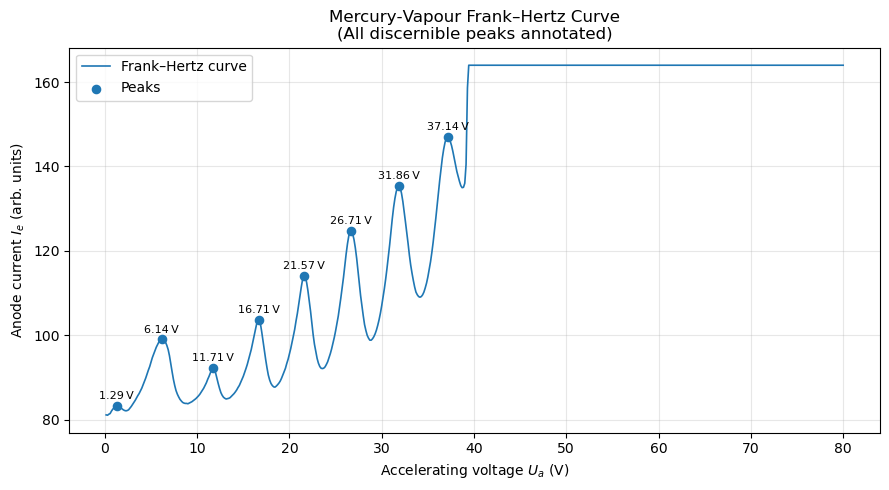

Peak voltages: [ 1.29  6.14 11.71 16.71 21.57 26.71 31.86 37.14]


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks     # pip install scipy if needed

# --------------------------------------------------------------------------- #
# 1.  Load the data from GitHub
# --------------------------------------------------------------------------- #
url = (
    "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/"
    "refs/heads/main/Frank%20Hertz%20Data/TASK%202.1.txt"
)

df = pd.read_csv(
    url,
    sep=";",            # semicolon‑separated
    skiprows=1,         # drop the “Mode;ramp” header line
    decimal=",",        # convert 12,34 → 12.34
)
df.columns = ["Ua_V", "Ie"]            # nicer column names

# --------------------------------------------------------------------------- #
# 2.  Find EVERY peak, but ignore the high‑voltage plateau
# --------------------------------------------------------------------------- #
# The plateau sits at 164 arb. units; use a threshold a bit below that
mask_dynamic = df["Ie"] < 160           # keep only the region with structure

# SciPy’s find_peaks: tweak `prominence` so tiny wiggles aren’t counted
peaks_rel, _ = find_peaks(df.loc[mask_dynamic, "Ie"], prominence=1)

# Convert to absolute indices in the original DataFrame
peaks_abs = df.loc[mask_dynamic].iloc[peaks_rel].index

peak_voltages  = df.loc[peaks_abs, "Ua_V"].values
peak_currents  = df.loc[peaks_abs, "Ie"].values

# --------------------------------------------------------------------------- #
# 3.  Plot
# --------------------------------------------------------------------------- #
plt.figure(figsize=(9, 5))
plt.plot(df["Ua_V"], df["Ie"], lw=1.2, label="Frank–Hertz curve")

# highlight peaks
plt.scatter(peak_voltages, peak_currents, zorder=3, s=35, marker="o", label="Peaks")
for v, i in zip(peak_voltages, peak_currents):
    plt.annotate(f"{v:.2f} V", xy=(v, i), xytext=(0, 5),
                 textcoords="offset points", ha="center", fontsize=8)

plt.title("Mercury‑Vapour Frank–Hertz Curve\n(All discernible peaks annotated)")
plt.xlabel("Accelerating voltage $U_a$ (V)")
plt.ylabel("Anode current $I_e$ (arb. units)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# --------------------------------------------------------------------------- #
# 4.  Save & show
# --------------------------------------------------------------------------- #
plt.savefig("5.png", dpi=300, bbox_inches="tight")          # high‑res PNG
plt.savefig("ionisation_curves.pdf", bbox_inches="tight")          # vector PDF
# plt.savefig("ionisation_curves.svg", bbox_inches="tight")        # vector SVG
plt.show()

print("Peak voltages:", np.round(peak_voltages, 2))


### task 2.2

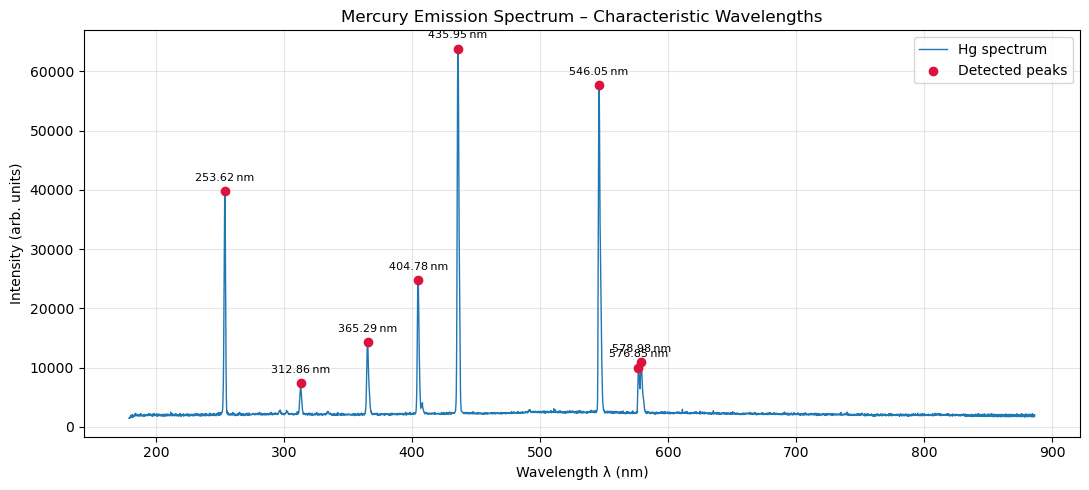

Detected peak wavelengths (nm):
[253.62 312.86 365.29 404.78 435.95 546.05 576.85 578.98]


In [8]:
import io, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks      # pip install scipy if missing

# --------------------------------------------------------------------------- #
# 1.  Download & parse the spectral data
# --------------------------------------------------------------------------- #
URL = (
    "https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/"
    "refs/heads/main/Frank%20Hertz%20Data/T2_2.txt"
)

raw = requests.get(URL, timeout=30).text
block = raw.split(">>>>>Begin Processed Spectral Data<<<<<")[1] \
           .split(">>>>>End Processed Spectral Data<<<<<")[0]

df = pd.read_csv(
        io.StringIO(block),
        sep=r"\s+",
        names=["λ_nm", "counts"],
        decimal=",",            # comma‑decimals → floats
        engine="python",
        on_bad_lines="skip"
     ).astype(float).sort_values("λ_nm").reset_index(drop=True)

# --------------------------------------------------------------------------- #
# 2.  Detect emission peaks
# --------------------------------------------------------------------------- #
peaks, _ = find_peaks(df["counts"], prominence=1000)   # adjust if needed
λ_peaks  = df.loc[peaks, "λ_nm"].values
I_peaks  = df.loc[peaks, "counts"].values

# --------------------------------------------------------------------------- #
# 3.  Plot (horizontal wavelength labels)
# --------------------------------------------------------------------------- #
plt.figure(figsize=(11, 5))
plt.plot(df["λ_nm"], df["counts"], lw=1, label="Hg spectrum")
plt.scatter(λ_peaks, I_peaks, color="crimson", zorder=3, label="Detected peaks")

for wl, inten in zip(λ_peaks, I_peaks):
    plt.annotate(
        f"{wl:.2f} nm",
        xy=(wl, inten),
        xytext=(0, 6),               # 6 px upward offset
        textcoords="offset points",
        ha="center", va="bottom",    # centre‑align horizontally
        fontsize=8,
        rotation=0                   # horizontal text
    )

plt.title("Mercury Emission Spectrum – Characteristic Wavelengths")
plt.xlabel("Wavelength λ (nm)")
plt.ylabel("Intensity (arb. units)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("6.png", dpi=300, bbox_inches="tight")
plt.show()


# --------------------------------------------------------------------------- #
# 4.  Console read‑out (wavelengths only)
# --------------------------------------------------------------------------- #
print("Detected peak wavelengths (nm):")
print(np.round(λ_peaks, 2))


### task 3.1

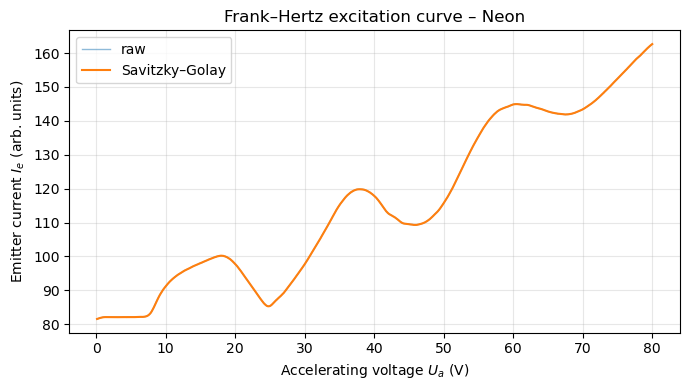

In [4]:
# Frank–Hertz excitation curve – Neon (task 3.1)

import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# -------------------------------------------------------------------
# 1. load the data ---------------------------------------------------
url = ("https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/"
       "refs/heads/main/Frank%20Hertz%20Data/task%203.1.txt")

df = pd.read_csv(
        url,
        sep=";",          # Semicolon-separated
        decimal=",",      # Commas are decimal points
        skiprows=1,       # Skip first line  (“Mode;ramp”)
        header=0          # Second line (“Ua;Ie”) becomes the header
     )

# -------------------------------------------------------------------
# 2. optional smoothing ---------------------------------------------
df["Ie_smooth"] = savgol_filter(df["Ie"], window_length=11, polyorder=2)

# -------------------------------------------------------------------
# 3. plot ------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(df["Ua"], df["Ie"], lw=1, alpha=0.5, label="raw")
plt.plot(df["Ua"], df["Ie_smooth"], lw=1.5, label="Savitzky–Golay")

plt.xlabel("Accelerating voltage $U_a$ (V)")
plt.ylabel("Emitter current $I_e$ (arb. units)")
plt.title("Frank–Hertz excitation curve – Neon")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# save high-resolution copy
plt.savefig("neon_excitation_curve.png", dpi=300, bbox_inches="tight")
plt.show()


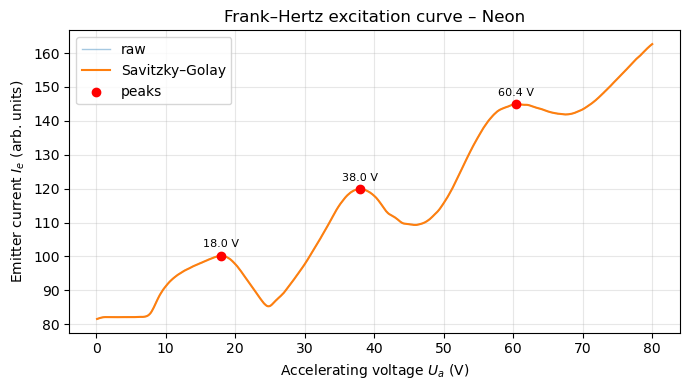

Peak voltages (V): 18.00, 38.00, 60.43


In [6]:
# Frank–Hertz excitation curve – Neon (task 3.1)
# now with peak markers
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# -------------------------------------------------------------------
# 1. load the data ---------------------------------------------------
url = ("https://raw.githubusercontent.com/rishabh107/Whitman-s-Library/"
       "refs/heads/main/Frank%20Hertz%20Data/task%203.1.txt")

df = pd.read_csv(
        url,
        sep=";",          # semicolon-separated
        decimal=",",      # commas are decimal points
        skiprows=1,       # skip first line  (“Mode;ramp”)
        header=0          # second line (“Ua;Ie”) becomes the header
     )

# -------------------------------------------------------------------
# 2. smoothing -------------------------------------------------------
df["Ie_smooth"] = savgol_filter(df["Ie"], window_length=11, polyorder=2)

# -------------------------------------------------------------------
# 3. peak detection --------------------------------------------------
# tweak 'distance' (points) or 'prominence' if you get too many/few peaks
peaks, _ = find_peaks(df["Ie_smooth"], distance=15, prominence=0.4)

# -------------------------------------------------------------------
# 4. plot ------------------------------------------------------------
plt.figure(figsize=(7, 4))

# raw + smooth traces
plt.plot(df["Ua"], df["Ie"], lw=1, alpha=0.4, label="raw")
plt.plot(df["Ua"], df["Ie_smooth"], lw=1.5, label="Savitzky–Golay")

# peak markers
plt.scatter(df.loc[peaks, "Ua"],
            df.loc[peaks, "Ie_smooth"],
            color="red", zorder=3, label="peaks")

# annotate each peak with its Ua value
for idx in peaks:
    ua = df.at[idx, "Ua"]
    ie = df.at[idx, "Ie_smooth"]
    plt.annotate(f"{ua:.1f} V", (ua, ie),
                 textcoords="offset points", xytext=(0, 6),
                 ha='center', fontsize=8)

plt.xlabel("Accelerating voltage $U_a$ (V)")
plt.ylabel("Emitter current $I_e$ (arb. units)")
plt.title("Frank–Hertz excitation curve – Neon")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("neon_excitation_curve_peaks.png", dpi=300, bbox_inches="tight")
plt.show()

# optional: print a quick list of the peak voltages
print("Peak voltages (V):", ", ".join(f"{df.at[i,'Ua']:.2f}" for i in peaks))
